In [3]:
# Import necessary packages
using PyPlot
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using AlgebraicMultigrid

Solve the momentum and continuity equations using a stream function-vorticity approach. Use a regular grid of 51x41 points. The model size is 1000x1500 km.

In [4]:
struct Grid
    x::Vector
    y::Vector
    nx::Int
    ny::Int
    W::Float64
    H::Float64
    dx::Float64
    dy::Float64
    Grid(W,H,nx,ny) = new(LinRange(0,W,nx),LinRange(0,H,ny),nx,ny,W,H,W/(nx-1),H/(ny-1))
end

In [5]:
function initial_conditions_leftright(grid::Grid)
    # Setup the initial density structure
    rho = zeros(grid.ny,grid.nx)
    for i in 1:grid.ny
        for j in 1:grid.nx
            if grid.x[j] < grid.W/2.
                rho[i,j] = 3200.
            else
                rho[i,j] = 3300.
            end
        end
    end
    
    return rho
end



initial_conditions_updown (generic function with 1 method)

In [6]:
# Set up the problem
function assemble_poisson_LHS(grid::Grid)
    
    dx = grid.dx
    dy = grid.dy
    nx = grid.nx
    ny = grid.ny
    nn = nx*ny
    @inline dof(i::Int64,j::Int64) = (j-1)*ny + i # Gerya 3.22

    # pre-allocate arrays to store indices and values
    row_index = zeros(Int64,5*nn) # up to 5 nonzeros per row
    col_index = zeros(Int64,5*nn)
    values = zeros(Float64, 5*nn)
    k=1
    for i in 1:ny
        for j in 1:nx
            row = dof(i,j)
            coef_center = -2/dx^2-2/dy^2
            coef_right  = 1/dx^2
            coef_left   = 1/dx^2
            coef_up     = 1/dy^2
            coef_down   = 1/dy^2
            # modify equations for dirichlet boundary condition f=0:
            if i==1 || i == ny || j==1 || j == nx
                row_index[k] = row
                col_index[k] = row
                values[k] = coef_center
                k+=1
            else        
                # center:
                row_index[k] = row
                col_index[k] = dof(i,j)
                values[k] = coef_center
                k+=1
                # left:
                row_index[k] = row
                col_index[k] = dof(i,j-1)
                values[k] = coef_left
                k += 1

                row_index[k] = row
                col_index[k] = dof(i,j+1)
                values[k] = coef_right
                k += 1

                row_index[k] = row
                col_index[k] = dof(i-1,j)
                values[k] = coef_up
                k+=1

                row_index[k] = row
                col_index[k] = dof(i+1,j)
                values[k] = coef_down
                k+=1
            end
        end
    end
    @views row_index = row_index[1:(k-1)]
    @views col_index = col_index[1:(k-1)]
    @views values = values[1:(k-1)]

    L = sparse(row_index,col_index,values)
    return L
end

function vorticity_rhs(grid::Grid,density::Matrix,gy::Float64,viscosity::Float64)
    dx = grid.dx
    dy = grid.dy
    nx = grid.nx
    ny = grid.ny
    nn = nx*ny
    rhs = zeros(nn,1)
    @inline dof(i::Int64,j::Int64) = (j-1)*ny + i # Gerya 3.22
    for i in 2:(ny-1)
        for j in 2:(nx-1)
            rhs[dof(i,j)] = gy* (density[i,j+1]-density[i,j-1])/2. /viscosity/dx
        end
    end
    return rhs
end

function get_velocity(grid::Grid,psi::Matrix)
    # Note that there was an error in the corresponding code in the textbook.
    dx = grid.dx
    dy = grid.dy
    nx = grid.nx
    ny = grid.ny
    nn = nx*ny
    vx = zeros(ny,nx)
    vy = zeros(ny,nx)
    @inline dof(i::Int64,j::Int64) = (j-1)*ny + i # Gerya 3.22
    for i in 2:(ny-1)
        for j in 2:(nx-1)
            vx[i,j] =  (psi[dof(i+1,j)] - psi[dof(i-1,j)])/(2*dy) #  d(psi)/dy
            vy[i,j] = -(psi[dof(i,j+1)] - psi[dof(i,j-1)])/(2*dx) # -d(psi)/dx
        end
    end
    return vx, vy
end


get_velocity (generic function with 1 method)

In [7]:
gy = 10.
viscosity = 1e21

# 0. Setup the computational grid
grid = Grid(1e6,1.5e6,41,31)
# 1. setup the density and the right-hand-side for the vorticity equation
rho = initial_conditions(grid)
# 2. assemble the left-hand-side (generic poisson equation)
L = assemble_poisson_LHS(grid)
vor_R = vorticity_rhs(grid,rho,gy,viscosity)
# 3. solve for vorticity
@time vor = L\vor_R
# solve for stream function
@time psi = L\vor
# retrieve the velocities
vx,vy = get_velocity(grid,psi)

println("Norm of vorticity: ",norm(vor),' ',size(vor))# Gerya: 3.1501e-12
println("Norm of psi: ",norm(psi),' ',size(psi))# Gerya: 0.2169
println("Norm of vx: ",norm(vx)," vy: ",norm(vy))# Gerya: 4.3619e-07, 6.6716e-07 (corrected code)

  0.003681 seconds (70 allocations: 1.638 MiB)
  0.003230 seconds (70 allocations: 1.638 MiB)
Norm of vorticity: 3.1501252299324312e-12 (1271, 1)
Norm of psi: 0.21691861280092356 (1271, 1)
Norm of vx: 4.362123196016672e-7 vy: 6.672065795221222e-7


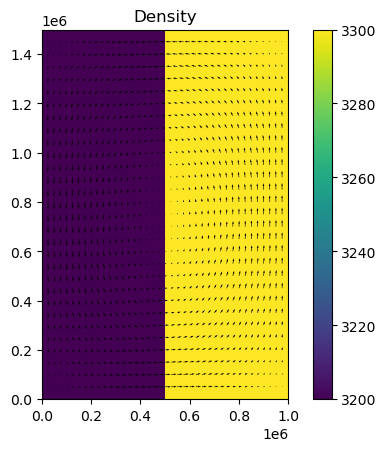

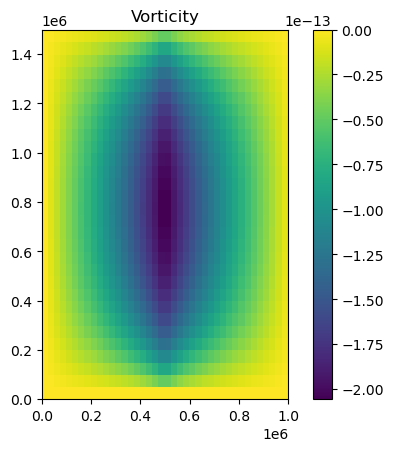

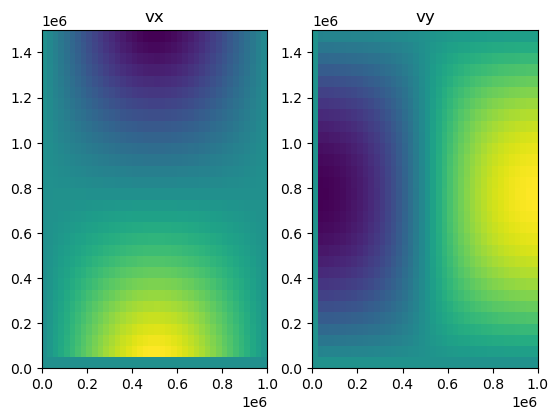

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/maxrudolph/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [6]:
# Visualization
figure()
h=pcolor(grid.x,grid.y,rho)
gca().set_aspect("equal")
quiver(grid.x,grid.y,vx,vy)
colorbar(h)
title("Density")
show()

figure()
pcolor(grid.x,grid.y,reshape(vor,grid.ny,grid.nx))
title("Vorticity")
gca().set_aspect("equal")
colorbar()
show()

fig, (ax1,ax2) = subplots(1,2)
ax1.pcolor(grid.x,grid.y,vx)
ax1.set_title("vx")
ax1.set_aspect("equal")

ax2.pcolor(grid.x,grid.y,vy)
ax2.set_title("vy")
ax2.set_aspect("equal")
show()